#Introduction

I found this dataset on kaggle and thought I will see how I can perform on it. See link below:

https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

## Summary about the dataset

* The dataset contains total 7348 images. The images are top view of a submersible pump impeller
* The pumps are categorised as 'defective' or 'OK' quality based on visual inspection
* Folders have been created for training and validation datasets
* Further, the images of defective and OK quality pumps are placed in sub-folders 'def_front' and 'ok_front' respectively.
* The folders and sub-folders allow the use of the Image Data Generator class of Keras i.e. ImageDataGenerator which is used for generating images using Image Augmentation techniques dynamically during training

# Getting started

This is a binary classification problem to identify the good quality pumps from the defective ones. Let's get on with it then!

In [7]:
# First, all the customaries.

import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Defining the directory with our training parts
train_dir = '/content/drive/MyDrive/Data/casting_data/train'

# Defining the directory with our validation parts
val_dir = '/content/drive/MyDrive/Data/casting_data/test'

Let's have a look at a defective and a OK sample each.

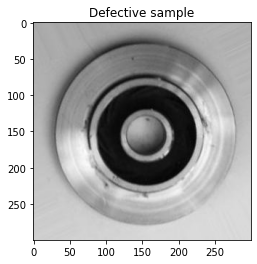

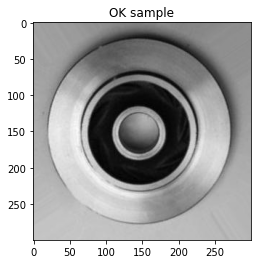

In [3]:
random.seed(0)
val_dir_def = val_dir+'/def_front/'
val_dir_ok = val_dir+'/ok_front/'
k = random.randrange(0, min(len(os.listdir(val_dir_def)), len(os.listdir(val_dir_ok))))

plt.title('Defective sample')
plt.imshow(mpimg.imread(val_dir_def+os.listdir(val_dir_def)[k]))

plt.figure()

plt.title('OK sample')
plt.imshow(mpimg.imread(val_dir_ok+os.listdir(val_dir_ok)[k]))

plt.show()

# Image Data Generator

The ImageDataGenerator generates batches of tensor image-data with real-time augmentation. I will try out and play with the following image augmentation measures, as need be:
* Rescale: Normalising the pixel data
* Horizontal and Vertical Shift: A shift to an image means moving all pixels of the image in one direction, such as horizontally or vertically, while keeping the image dimensions the same
* Random Brightness: The brightness of the image can be augmented by either randomly darkening images, brightening images, or both
* Random Rotation: A rotation augmentation randomly rotates the image clockwise by a given number of degrees
* Shear Range: Shear is a transformation where the image is skewed by the given angle in degrees in counter-clockwise direction
* Random Zoom: A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively
* Horizontal and Vertical Flip: An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively
* Fill Mode: This allows us to specify how any missing pixels are filled.'nearest' will lead to more naturally looking augmented output images

It turns out, the best model accuracy was achieved by applying just the rescaling. All the rest were not of much help, or indeed were counterproductive.

"When the solution is simple, God is answering."

In [45]:
train_datagen = ImageDataGenerator(
      rescale=1./255)#,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=20,
      # brightness_range=[0.95,1.05],
      # rotation_range = 45,
      # zoom_range=0.05,
      # horizontal_flip=True,
      # vertical_flip=True,
      # fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=128,
        color_mode="grayscale",       # Grayscale images are easier to handle. For this classification task the RGB colours are not important.
        class_mode='binary')          # Since we use binary_crossentropy loss, we need binary labels

validation_generator = validation_datagen.flow_from_directory(
        val_dir,  # This is the source directory for validation images
        target_size=(300, 300),
        batch_size=32,
        color_mode="grayscale",
        class_mode='binary')

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [5]:
input_img_shape = train_generator.image_shape
input_img_shape

(300, 300, 1)

Let's build the model!

# Modelling

We'll keep it simple with just the following types of layers:
* 2X Conv2D
* 2X Max pooling
* Flatten
* Dense

In [46]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2, input_shape=input_img_shape),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    # Flatten the results to feed into the dense layer
    tf.keras.layers.Flatten(),
    
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('defective') and 1 for the other ('ok')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 23104)             0         
                                                                 
 dense_24 (Dense)            (None, 128)             

## Callbacks

Let's define two callback functions, Early Stopping and Model Checkpoint, to stop training when the validation loss no longer continues to decrease and save the model which has the highest validation accuracy, respectively.

In [47]:
es = EarlyStopping(monitor='accuracy', patience=5, mode='max')
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [48]:
history = model.fit(
      train_generator,  
      epochs=25,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[es, mc]
        )



Epoch 1/25
52/52 [==============================] - 32s 582ms/step - loss: 0.7095 - accuracy: 0.5464 - val_loss: 0.6450 - val_accuracy: 0.6336
Epoch 2/25
52/52 [==============================] - 31s 590ms/step - loss: 0.5615 - accuracy: 0.7065 - val_loss: 0.4720 - val_accuracy: 0.7692
Epoch 3/25
52/52 [==============================] - 31s 597ms/step - loss: 0.4129 - accuracy: 0.8051 - val_loss: 0.3332 - val_accuracy: 0.8406
Epoch 4/25
52/52 [==============================] - 31s 596ms/step - loss: 0.3345 - accuracy: 0.8577 - val_loss: 0.2889 - val_accuracy: 0.8993
Epoch 5/25
52/52 [==============================] - 31s 595ms/step - loss: 0.2718 - accuracy: 0.8976 - val_loss: 0.2188 - val_accuracy: 0.9273
Epoch 6/25
52/52 [==============================] - 31s 595ms/step - loss: 0.2123 - accuracy: 0.9276 - val_loss: 0.1679 - val_accuracy: 0.9594
Epoch 7/25
52/52 [==============================] - 31s 593ms/step - loss: 0.1806 - accuracy: 0.9365 - val_loss: 0.1475 - val_accuracy: 0.9580

In [49]:
from tensorflow.keras.models import load_model

In [54]:
saved_model = load_model('best_model.h5')

In [55]:
# evaluate the model
_, train_acc = saved_model.evaluate(train_generator, verbose=0)
_, test_acc = saved_model.evaluate(validation_generator, verbose=0)
print('Training accuracy: %.3f\nValidation accuracy: %.3f' % (train_acc, test_acc))

Training accuracy: 0.998
Validation accuracy: 0.997


# Results

Finally, we plot the history of the loss and accuracy during training.

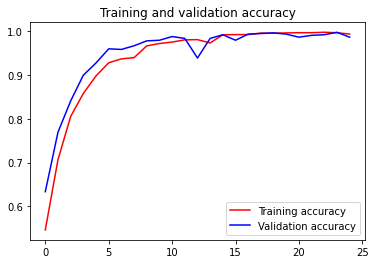

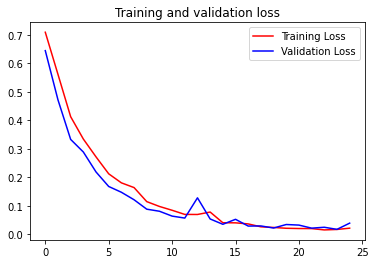

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These are excellent results achieving virtually 100% accuracy within 25 epochs. Voila!